In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Iterated and Sequential Importance Sampling

> “The past is important, sir,” said Rebus, taking his leave.  
> — Ian Rankin, *The Black Book*

This chapter gives an introduction to sequential simulation methods, a collection of algorithms that build both on MCMC methods and importance sampling, with importance sampling playing a key role. We will see the relevance of importance sampling and the limitations of standard MCMC methods in many settings, as we try to make the reader aware of important and ongoing developments in this area. In particular, we present an introduction to *Population Monte Carlo* (Section 14.4), which extends these notions to a more general case, and subsumes MCMC methods.

##  Introduction

At this stage of the book, importance sampling, as presented in Chapters 3 and 4, may appear as a precursor of MCMC methods. This is because both approaches use the ratio of *target/importance* distributions,  
$$
f / g,
$$
to build approximations to the target distribution $ f $ and related integrals, and because MCMC methods appear to provide a broader framework, in particular because they can derive proposals from earlier generations. This chapter will show that this vision is not quite true. Importance sampling can also be implemented with *dependent* proposal distributions and adaptive algorithms.

> **Note:** Here, we use a vocabulary slightly different from other chapters, often found in the particle filter literature: generations from importance distributions are often called **particles**, and importance distributions will be called **proposal distributions**. Also, we restrict the use of the adjective *sequential* to settings where observations $ x_t $ (or *targets*) appear sequentially in a certain time process, rather than all at once. For other common uses of the word, we will prefer the denominations *iterated* or *repeated*.

that are much easier to build than in MCMC settings (Section 7.6.3), while providing unbiased estimators of integrals of interest (if all normalizing constants are known).

Importance sampling naturally enhances parallel sampling and there are settings, as in Example 9.2, where MCMC has a very hard time converging to the distribution of interest while importance sampling, based on identical proposals, manages to reach regions of interest for the target distribution (Section 14.4).

Importance sampling is also paramount in sequential settings, where a constant modification of the target distribution occurs with high frequency and precludes the use of standard MCMC algorithms because of computational constraints. The books by Doucet et al. (2001) and Liu (2001) are dedicated to this topic of sequential sampling methods and we thus refer the reader to those for a more complete treatment of this topic.

## Generalized Importance Sampling

As already stated in the above paragraph, an incorrect impression that might be drawn from the previous chapters is that importance sampling is solely a forerunner of MCMC methods, and that the latter overshadows this technique. As shown below in Section 14.4, a deeper understanding of the structures of both importance sampling and MCMC methods can lead to superior hybrid techniques that are importance sampling at the core, that is, they rely on unlikeness at any given iteration, but borrow strength from iterated methods and MCMC proposals. We first see how iterated adaptive importance sampling is possible and why dependent steps can be embedded within importance sampling without the negative consequence on the importance sampling fundamental identity.

A first basic remark about importance sampling is that its fundamental unbiasedness property (14.1) is not necessarily jeopardized by dependencies in the sample. For instance, the following result was established by MacEachern et al. (1999).

**Lemma 14.1.** If $ f $ and $ g $ are two densities, with $ \text{supp}(f) \subseteq \text{supp}(g) $, and if  
$$
\omega(x) = \frac{f(x)}{g(x)}
$$  
is the associated importance weight, then for any kernel $ K(x,z') $ with stationary distribution $ f $,
$$
\int f(x) K(x,z') g(z) dz = f(z').
$$

This invariance result is also in obvious corollary of the importance sampling fundamental identity (3.9), which we repeat here:

$$
\mathbb{E}_f[h(x)] = \int h(x) \frac{f(x)}{g(x)} g(x) dx.
$$

However, its consequences are quite interesting. Lemma 14.1 implies, in particular, that MCMC transitions can be forced upon points of an importance sample with no effect on the weights. Therefore, the modification of an importance sample by MCMC transitions does not affect the unbiasedness associated with the importance estimator (3.8) (even though it may modify its variance structure), since

$$
\mathbb{E}[\omega(X) h(X')] = \int \omega(x) h(x') K(x, x') g(x) \, dx \, dx' = \mathbb{E}_f [h(X')]
$$

for any $ f $-integrable function $ h $. One may wonder why we need to apply an MCMC step in addition to importance sampling. The reason is that, since the MCMC kernel is tuned to the target distribution, it may correct to some extent a poor choice of importance function. This effect is not to be exaggerated, though, given that the weights do not change. For example, a point $ x $ with a large (small) weight $ \omega(x) = f(x)/g(x) $, when moved to $ x' $ by the kernel $ K(x, x') $, does keep its large (small) weight, even if $ x' $ is less (more) likely than $ x $ in terms of $ f $. This drawback is linked to the fact that the kernel, rather than the proposal within the kernel, is used in Lemma 14.1. Section 14.4 will discuss more adaptive schemes that bypass this difficulty.

Although the relevance of using MCMC steps will become clearer in Section 14.3 for sequential settings, we point out at this stage that other generalizations can be found in the literature as the *dynamic weighting* of Wun and Liang (1997), where a sample of $ (x_t, \omega_t) $ is produced, with joint distribution $ q(x, \omega) $ such that

$$
\int \omega \, g(x, \omega) \, d\omega \propto f(x).
$$

See Note 14.6.2 for more details on the possible implementations of this approach.

---

## Particle Systems

### Sequential Monte Carlo

While this issue is rather peripheral to the purpose of the book, which focuses on “mainstream” statistical models, there exist practical settings where a sequence of target distributions $ ( \pi_t )_t $ is available (to some extent like normalizing or marginalizing) and needs to be approximated under severe time/storage constraints. Such settings emerged in military and safety applications. For instance, $ \pi_t $ may be a posterior distribution on the position and the speed of a plane at a time given some noisy measures on these quantities. The difficulty of the problem is the **time constraint**: we assume that this constraint is too tight to hope to produce a reasonable Monte Carlo approximation using a basic method with repeated resampling (like regular importance sampling) or dependent (like MCMC algorithms) sampling.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Target distribution: standard normal (f)
def f(x):
    return norm.pdf(x)

# Proposal distribution: Laplace (g)
def g(x):
    return laplace.pdf(x)

# Importance weight ω(x) = f(x) / g(x)
def importance_weight(x):
    return f(x) / g(x)

# Function h(x) whose expectation under f we want to estimate
def h(x):
    return x**2

# Optional MCMC step: simple Metropolis kernel
def mcmc_step(x, f, proposal_std=1.0):
    x_new = x + np.random.normal(0, proposal_std)
    accept_ratio = min(1, f(x_new) / f(x))
    if np.random.rand() < accept_ratio:
        return x_new
    else:
        return x

# Generalized importance sampling with optional MCMC
def generalized_importance_sampling(n_samples=10000, use_mcmc=False):
    # Sample from proposal g
    samples = laplace.rvs(size=n_samples)
    weights = importance_weight(samples)

    if use_mcmc:
        samples_mcmc = np.array([mcmc_step(x, f) for x in samples])
    else:
        samples_mcmc = samples

    # Estimate expectation
    weighted


In [2]:
import random
import math

# Example: Target f is a standard normal; proposal g is a normal with mean=2, std=1

def f(x):
    """Target distribution: standard normal"""
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x**2)

def g(x):
    """Proposal distribution: normal with mean=2, std=1"""
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * (x - 2)**2)

def sample_g():
    """Sample from g: normal(2, 1) using Box-Muller method"""
    u1, u2 = random.random(), random.random()
    z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return z + 2  # mean shift to 2

def h(x):
    """Function to compute expectation of"""
    return x**2  # For example, E_f[x^2]

def importance_sampling(n_samples=10000):
    weighted_sum = 0.0
    weight_total = 0.0

    for _ in range(n_samples):
        x = sample_g()
        weight = f(x) / g(x)
        weighted_sum += h(x) * weight
        weight_total += weight

    return weighted_sum / weight_total

print("Estimated E_f[h(x)]:", importance_sampling())


Estimated E_f[h(x)]: 0.7634425110903744


In [3]:
def transition(x):
    """State transition model: x_t = x_{t-1} + noise"""
    return x + random.gauss(0, 1)

def observation_likelihood(x, y):
    """Likelihood of observing y given state x"""
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * (y - x)**2)

def resample(particles, weights):
    """Systematic resampling"""
    N = len(particles)
    positions = [(i + random.random()) / N for i in range(N)]
    indexes = []
    cumsum = [0.0]
    for w in weights:
        cumsum.append(cumsum[-1] + w)
    j = 0
    for p in positions:
        while p > cumsum[j + 1]:
            j += 1
        indexes.append(j)
    return [particles[i] for i in indexes]

def smc(num_particles=100, num_steps=10, true_states=None, observations=None):
    # Initialize particles
    particles = [random.gauss(0, 1) for _ in range(num_particles)]
    
    for t in range(num_steps):
        # Predict
        particles = [transition(p) for p in particles]

        # Weight
        y = observations[t]
        weights = [observation_likelihood(p, y) for p in particles]
        total = sum(weights)
        weights = [w / total for w in weights]  # normalize

        # Estimate
        mean = sum(p * w for p, w in zip(particles, weights))
        print(f"Step {t + 1}, Estimated State: {mean:.3f}, Observation: {y}")

        # Resample
        particles = resample(particles, weights)

# Example usage
true_states = [0.0]
observations = []
for _ in range(10):
    next_state = true_states[-1] + random.gauss(0, 1)
    obs = next_state + random.gauss(0, 1)
    true_states.append(next_state)
    observations.append(obs)

smc(observations=observations, num_steps=10)


Step 1, Estimated State: -0.670, Observation: -1.1373515717142813
Step 2, Estimated State: 0.460, Observation: 1.1688760988798848
Step 3, Estimated State: 0.516, Observation: 0.7068048244711244
Step 4, Estimated State: 1.539, Observation: 2.157627356277535
Step 5, Estimated State: 1.827, Observation: 2.1529321263298193
Step 6, Estimated State: 1.796, Observation: 1.661424787634517
Step 7, Estimated State: 2.101, Observation: 2.2341526012621022
Step 8, Estimated State: 2.520, Observation: 2.697409088050074
Step 9, Estimated State: 1.395, Observation: 0.8943579257948785
Step 10, Estimated State: 2.298, Observation: 2.7161492175530464


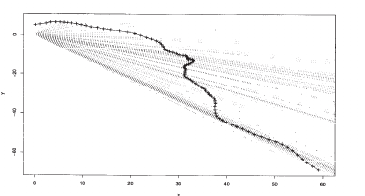


## Example .2: Target Tracking

The original example of Gordon et al. (1993) is a tracking problem where an object (e.g., a particle, a pedestrian, or a ship) is observed through some noisy measurement of its angular position $ Z_t $ at time $ t $. Of interest are the position $ (X_t, Y_t) $ of the object in the plane and its speed $ (X_t, Y_t) $ (using standard physics notation). The model is then discretized as

$$
\begin{aligned}
X_t &= X_{t-1} + \tau \varepsilon^x_t \\
Y_t &= Y_{t-1} + \tau \varepsilon^y_t \\
Z_t &= \arctan\left(\frac{Y_t}{X_t}\right) + \eta \varepsilon^z_t
\end{aligned}
$$

where $ \varepsilon^x_t, \varepsilon^y_t, \varepsilon^z_t \sim \mathcal{N}(0, 1) $ are independent standard normal random variables.

---

Whatever the reason for tracking this object, the distribution of interest is 

$$
\pi(\theta_t) = \pi(\theta_t \mid z_{1:t}),
$$

where $ \theta_t = (\tau, \eta, X_t, Y_t) $ and $ z_{1:t} $ denotes (in the signal processing literature) the vector 

$$
z_t = (z_1, \dots, z_t).
$$

The prior distribution on this model includes the speed propagation equation above, as well as priors on $ \tau, \eta $ and the initial values $ (x_0, y_0, \theta_0, \eta_0) $.

---

**Figure 14.1** below shows a simulated sequence $ (X_t, Y_t) $ as well as the corresponding $ Z_t $, in a representation inspired by the graph in Gilks and Berzuini (2001).



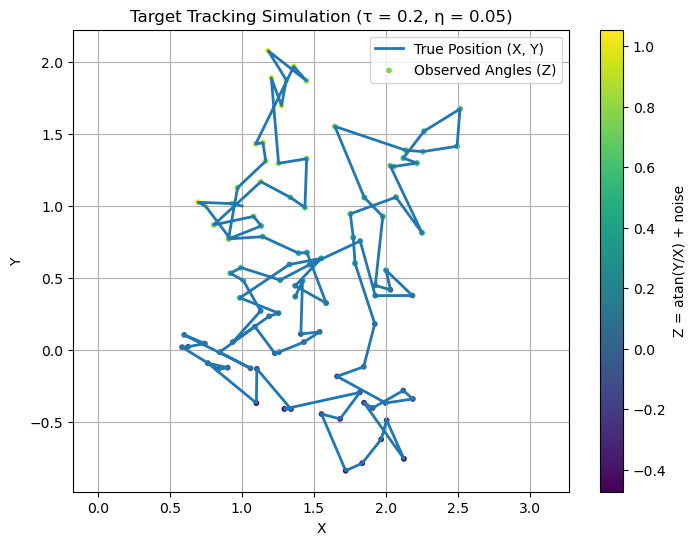

In [4]:
import math
import random
import matplotlib.pyplot as plt

# Parameters
T = 100  # Number of time steps
tau = 0.2
eta = 0.05

# Initial positions
X = [1.0]
Y = [1.0]
Z = []

# Simulation loop
for t in range(1, T + 1):
    # Sample standard normal noise
    eps_x = random.gauss(0, 1)
    eps_y = random.gauss(0, 1)
    eps_z = random.gauss(0, 1)

    # Propagate position
    x_new = X[-1] + tau * eps_x
    y_new = Y[-1] + tau * eps_y
    z_new = math.atan2(y_new, x_new) + eta * eps_z

    X.append(x_new)
    Y.append(y_new)
    Z.append(z_new)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(X, Y, label="True Position (X, Y)", linewidth=2)
plt.scatter(X[1:], Y[1:], c=Z, cmap="viridis", s=10, label="Observed Angles (Z)")
plt.colorbar(label="Z = atan(Y/X) + noise")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Target Tracking Simulation (τ = 0.2, η = 0.05)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


### Hidden Markov Models

A family of models where sequential importance sampling can be used is the family of *hidden Markov models* (abbreviated to **HMM**). They consist of a bivariate process $ (X_t, Z_t) $, where the subprocess $ (Z_t) $ is a homogeneous Markov chain on a state space $ \mathcal{Z} $ and, conditional on $ (Z_t) $, $ (X_t) $ is a series of random variables on $ \mathcal{X} $ such that the conditional distribution of $ X_t $ only depends on $ Z_t $, as represented in Figure 14.2. When $ \mathcal{Z} $ is discrete, we have, in particular,

$$
Z_t \mid Z_{t-1} \sim P(Z_t = j \mid Z_{t-1} = i) = p_{ij}, \\
X_t \mid Z_t \sim f(x \mid s_t),
$$

where $ \xi_1, \dots, \xi_k $ denote the different values of the parameter. The process $ (Z_t) $ which is usually referred to as the **regime** or the **state** of the model, is not observable (hence, *hidden*) and inference has to be carried out only in terms of the observable process $ (X_t) $.

Numerous phenomena can be modeled this way. For instance, Example 14.2 is a special case of an HMM where, by a switch in notation, the observable is $ Z_t $ and the hidden chain is $ (X_t, Y_t) $.

---
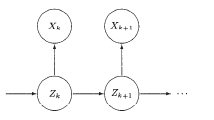


**Fig.2**: Directed acyclic graph (DAG) representation of the dependence structure of a hidden Markov model, where $ (X_t) $ is the observable process and $ (Z_t) $ the hidden process.

When $ (Z_t) $ is a Markov chain on a discrete space, the hidden Markov model is often called, somehow illogically, a **hidden Markov chain**. In the following example (Example 14.2), the support of $ Z_t $ is continuous.

In the discrete case, the predictive distribution is given by

$$
\pi_t(z_t \mid z_{t-1}, \mathbf{x}_{1:t-1}) = \pi_t(z_t \mid z_{t-1})
$$

as an importance function for the last component $z_t$ of $z_t$, and the corresponding importance weight is

$$
\omega_i \propto \omega_{i-1} \frac{\pi_t(z_t \mid x_{1:t})}{\pi_{t-1}(z_{t-1} \mid x_{1:t-1}) r_t(z_t \mid z_{t-1})}
$$

or equivalently,

$$
\omega_i \propto \omega_{i-1} f_t(x_t \mid z_t)
$$

where $\pi_t(z_t \mid x_{1:t})$ is the conditional distribution of $z_t$ given the past of the Markov chain, which collapses to being conditional only on $z_{t-1}$ because of the Markov property.

---

### 14.3.3 Weight Degeneracy

There is a fundamental difficulty with a sequential application of the importance sampling technique. The importance weight at time $t$ gets updated by a recursive formula of the type

$$
\omega_i^{(t)} \propto \omega_i^{(t-1)} \frac{f_t(x_t^{(i)} \mid z_t^{(i)})}{g_t(z_t^{(i)})}
$$

where $g_t$ is the importance function for the additional component of the state space at time $t$, like $f_t(x_t^{(i)})/g_t(z_t^{(i)})$. See also the analytical expression above. In this case,

$$
\omega_i^{(t)} \propto \exp\left\{ \sum_{l=1}^t \log \frac{f_l(x_l^{(i)})}{g_l(z_l^{(i)})} \right\}
$$

If $g_t$ and $f_t$ are both independent of $t$, and using the Law of Large Numbers for the sum in the exponential, we see that the right-hand term above is approximately exponential in $t$.



In [5]:
import numpy as np

def sequential_importance_sampling(T, N, observations, phi=0.95, q=0.1, r=1.0):
    """
    Sequential Importance Sampling (SIS) for a linear Gaussian state-space model.

    Args:
        T (int): Number of time steps
        N (int): Number of particles
        observations (np.ndarray): Observed data (length T)
        phi (float): State transition coefficient
        q (float): Process noise variance
        r (float): Observation noise variance

    Returns:
        particles (np.ndarray): Particle states (N x T)
        weights (np.ndarray): Normalized weights (N)
    """
    # Initialize particles and weights
    particles = np.zeros((N, T))
    weights = np.ones(N) / N  # Start with uniform weights

    # Initialize first state from prior
    particles[:, 0] = np.random.normal(0, np.sqrt(q / (1 - phi**2)), size=N)

    for t in range(T):
        if t > 0:
            # Propagate particles using transition model
            particles[:, t] = phi * particles[:, t-1] + np.random.normal(0, np.sqrt(q), size=N)

        # Compute importance weights (likelihood of observation given state)
        likelihoods = (1 / np.sqrt(2 * np.pi * r)) * np.exp(
            -0.5 * ((observations[t] - particles[:, t])**2) / r
        )
        weights *= likelihoods

        # Normalize weights to sum to 1 for numerical stability
        weights_sum = np.sum(weights)
        if weights_sum == 0:
            weights = np.ones(N) / N  # Avoid division by zero
        else:
            weights /= weights_sum

        # (No resampling step in basic SIS)

    return particles, weights

# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    T = 50
    phi = 0.95
    q = 0.1
    r = 1.0
    true_states = np.zeros(T)
    observations = np.zeros(T)
    true_states[0] = np.random.normal(0, np.sqrt(q / (1 - phi**2)))
    observations[0] = true_states[0] + np.random.normal(0, np.sqrt(r))
    for t in range(1, T):
        true_states[t] = phi * true_states[t-1] + np.random.normal(0, np.sqrt(q))
        observations[t] = true_states[t] + np.random.normal(0, np.sqrt(r))

    # Run SIS
    N = 500  # Number of particles
    particles, weights = sequential_importance_sampling(T, N, observations, phi, q, r)

    # Estimate posterior mean for each time step
    estimated_states = np.average(particles, axis=0, weights=weights)
    print("Estimated states:", estimated_states)
    print("True states:", true_states)


Estimated states: [-0.65364197 -0.25277421 -0.68016934 -0.40514132 -0.82989502 -1.02865424
 -0.99530253 -1.07530546 -0.75336349 -0.52674758 -0.69541203 -0.34853819
 -0.3354351  -0.30149786 -0.31320661 -0.2796291   0.16487909  0.68958805
  0.60007962  0.24959182  0.94050756  0.81087163  0.75070649  0.79689104
  0.76525896  0.96360143  1.02584682  0.92678726  0.7846949   1.09625865
  0.91095022  0.70395104  0.71984763  0.90770269  0.62011564  0.40324256
  0.43228265 -0.06710316  0.05744503 -0.20803754 -0.31425275 -0.23290008
  0.02980328 -0.11574693  0.34736439  0.50563693  0.59728862  0.46482668
  0.14835147 -0.0475763 ]
True states: [-1.02429557 -1.42898519 -1.16031096 -1.23095411 -1.36079397 -1.47555076
 -0.9331318  -0.42966401 -0.54696618 -0.77136896 -0.90022211 -0.30189156
 -0.25633737 -0.08029986  0.39925062  0.5467432   0.42732528  0.94171844
  1.03183892  1.20847997  1.3981693   1.53172217  0.89917763  0.93556588
  0.99250429  0.64684144  0.40612861  0.50991295  0.63686991  0.606